In [1]:
from cvxopt import matrix, solvers
import numpy as np
import matplotlib.pyplot as plt
import time
import math
import random
import decimal
import copy
from IPython.display import clear_output
solvers.options['show_progress'] = False

In [30]:
class Agent:
    def __init__(self, agnt_id, i_state, g_state, vg, wg, p_horizon=1, u_horizon=1):
        self.agnt_id = agnt_id
        self.i_state = np.array(i_state)
        self.g_state = np.array(g_state)
        self.c_state = self.i_state
        self.p_horizon = p_horizon
        self.u_horizon = u_horizon
        self.vg = vg
        self.wg = wg
        self.agent_radius = 2
        self.dt = 0.1
        
    def get_P_q_x(self):
        P_x_ = np.ones((1,2*self.p_horizon))
        d_th = np.ones((self.p_horizon)) # wg1, wg1+wg2, wg1+wg2+wg3
        s = 0
        for i in range(self.p_horizon):
            s = s + self.wg
            d_th[i] = s     
        th_ = np.ones((self.p_horizon)) # th0+wg1*dt, th0+(wg1+wg2)*dt, th0+(wg1+wg2+wg3)*dt
        th_0 = self.c_state[2]   
        for i in range(self.p_horizon):
            th_[i] = th_0 + d_th[i]*self.dt        
        d_x = np.ones((self.p_horizon)) # contains a, b, c
        for i in range(self.p_horizon):
            d_x[i] = np.cos(th_[i])*self.dt       
        d_w = np.ones((self.p_horizon)) # contains d, e, f
        for i in range(self.p_horizon):
            d_w[i] = -self.vg*np.sin(th_[i])*self.dt**2           
        s_dw = np.ones((self.p_horizon)) # contains d+e+f, e+f, f
        for i in range(self.p_horizon):
            s_dw[i] = np.sum(d_w[i:self.p_horizon])      
        P_x_[0,0:self.p_horizon] = d_x
        P_x_[0,self.p_horizon:] = s_dw        
        P_x = P_x_.T@P_x_
        
        ### Solving for q_x
        q_x = np.ones((2*self.p_horizon))
        x_0 = self.c_state[0]
        v_sum = 0
        w_sum = 0
        for i in range(self.p_horizon):
#             v_sum = v_sum + self.vg[i]*d_x[0,i]
            w_sum = w_sum + self.wg*s_dw[i]
            
        z = x_0 - w_sum - self.g_state[0]
        q_x[0:self.p_horizon] = 2*z*d_x
        q_x[self.p_horizon:] = 2*z*s_dw 
        return P_x, q_x
    
    def get_P_q_y(self):
        
        P_y_ = np.ones((1,2*self.p_horizon))
        
        d_th = np.ones((1,self.p_horizon)) # wg1, wg1+wg2, wg1+wg2+wg3
        s = 0
        for i in range(self.p_horizon):
            s = s + self.wg
            d_th[0,i] = s
        
        th_ = np.ones((1,self.p_horizon)) # th0+wg1*dt, th0+(wg1+wg2)*dt, th0+(wg1+wg2+wg3)*dt
        th_0 = self.c_state[2]   
        for i in range(self.p_horizon):
            th_[0,i] = th_0 + d_th[0,i]*self.dt
        
        d_y = np.ones((1,self.p_horizon)) # contains a, b, c
        for i in range(self.p_horizon):
            d_y[0,i] = np.sin(th_[0,i])*self.dt
        
        d_w = np.ones((1,self.p_horizon)) # contains d, e, f
        for i in range(self.p_horizon):
             d_w[0,i] = self.vg*np.cos(th_[0,i])*self.dt**2
            
        s_dw = np.ones((1,self.p_horizon)) # contains d+e+f, e+f, f
        for i in range(self.p_horizon):
            s_dw[0,i] = np.sum(d_w[0,i:self.p_horizon])
            
        
        P_y_[0,0:self.p_horizon] = d_y
        P_y_[0,self.p_horizon:] = s_dw
        
        P_y = P_y_.T@P_y_
        
        ### Solving for q_y
        q_y = np.ones((2*self.p_horizon))
        y_0 = self.c_state[1]
        w_sum = 0
        for i in range(self.p_horizon):
            w_sum = w_sum + self.wg*s_dw[0,i]
            
        z = y_0 - w_sum - self.g_state[1]
        q_y[0:self.p_horizon] = 2*z*d_y
        q_y[self.p_horizon:] = 2*z*s_dw 
        
        return P_y, q_y
        
    def get_P_q_theta(self):
        P_theta = np.zeros((2*self.p_horizon,2*self.p_horizon))
        P_theta[self.p_horizon:,self.p_horizon:]=self.dt**2*np.ones((self.p_horizon,self.p_horizon))
        
        q_theta = np.zeros((2*self.p_horizon))
        theta_0 = self.c_state[2]
        theta_g = self.g_state[2]
        q_theta[self.p_horizon:]=2*(theta_0 - theta_g)*self.dt * np.ones((self.p_horizon))
    
        return P_theta, q_theta
    
    def get_P_q(self):
        px, qx = self.get_P_q_x()
        py, qy = self.get_P_q_y()
        ptheta, qtheta = self.get_P_q_theta()
        P = 2*matrix(px+py+ptheta, tc='d')
        q = matrix(qx+qy+qtheta, tc='d')
        return P, q
    
    def pred_controls(self):
        # define the cost function here and optimize the controls to minimize it

        P_x, q_x = self.get_P_q_x()
        P_y, q_y = self.get_P_q_y()
        P_theta, q_theta = self.get_P_q_theta()

        P, q = self.get_P_q()

        # Constraints
        v_bound = 5
        w_bound = 0.1
        v_ub = 10 #*np.ones((self.p_horizon,1))
        v_lb = 0 #*np.ones((self.p_horizon,1))
        w_ub = 0.5 #*np.ones((self.p_horizon,1))
        w_lb = 0.5 #*np.ones((self.p_horizon,1))
        
        h = matrix([v_ub, w_ub, v_lb, w_lb, self.vg + v_bound, self.wg + w_bound, -(self.vg - v_bound), -(self.wg - w_bound)],tc='d')
# #         h = matrix(np.concatenate((v_ub, v_lb, w_ub, w_lb, np.reshape(self.vg,(1,1))+v_bound, -(np.reshape(self.vg,(1,1))-v_bound), np.reshape(self.wg,(1,1))+w_bound, -(np.reshape(self.wg,(1,1))-w_bound) ),axis=0), tc='d')        
        G = matrix(np.concatenate( (np.eye(2*self.p_horizon),-np.eye(2*self.p_horizon), np.eye(2*self.p_horizon), -np.eye(2*self.p_horizon)), axis=0), tc='d')
#         g_mat = np.array([[0,-1],[-1,0],[1,0],[0,1],[1,0],[-1,0],[0,1],[0,-1]])
#         h = matrix(np.array([w_ub, 0, v_ub, w_ub, self.vg+5,-(self.vg-5),self.wg+0.1,-(self.wg-0.1)]),tc='d')
#         G = matrix(g_mat,tc='d')
        sol=solvers.qp(P, q, G, h)
#         return sol
        self.vg = sol['x'][0]
        self.wg = sol['x'][1]
#         self.v = self.vg[0]
#         self.w = self.wg[0]
#             diff_v = self.vg[0] - self.v
#             diff_w = self.wg[0] - self.w
#         return sol
        
        
    def non_hol_update(self):
        self.c_state[2] = self.c_state[2] + self.wg*self.dt
        self.c_state[0] = self.c_state[0] + self.vg*np.cos(self.c_state[2])*self.dt
        self.c_state[1] = self.c_state[1] + self.vg*np.sin(self.c_state[2])*self.dt
        
    def draw_circle(self):
        th = np.arange(0,2*np.pi,0.01)
        xunit = self.agent_radius * np.cos(th) + self.c_state[0]
        yunit = self.agent_radius * np.sin(th) + self.c_state[1]
        return xunit, yunit  
    
    def get_traj(self,k):
        state = copy.deepcopy(self.c_state)
        for i in range(k,self.p_horizon):
            state[2] = state[2] + self.wg[i]*self.dt
            state[0] = state[0] + self.vg[i]*np.cos(state[2])*self.dt
            state[1] = state[1] + self.vg[i]*np.sin(state[2])*self.dt
            self.x_traj.append(state[0])
            self.y_traj.append(state[1])
        
        
        

In [31]:
p_horizon = 1
u_horizon = 1
vg = 10 #*np.ones((p_horizon))
wg = 0.1 #*np.ones((p_horizon)) 

In [32]:
a = Agent(1, [0,0,np.deg2rad(45)],[80,50,np.deg2rad(45)], vg, wg, p_horizon, u_horizon)

In [33]:
P, q = a.get_P_q()
print(P)
print(q)

[ 2.00e-02  0.00e+00]
[ 0.00e+00  4.00e-02]

[-1.83e+01]
[ 4.42e+00]



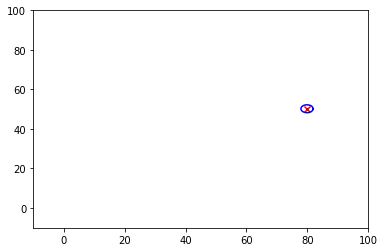

<Figure size 432x288 with 0 Axes>

In [34]:
th = 0.5
timeout = 150
while( (np.linalg.norm(a.c_state-a.g_state)>th) and timeout>0):
# for i in range(10):
    a.pred_controls()
    a.non_hol_update()
#     print(a.c_state)
    clear_output(wait=True)
    x,y = a.draw_circle()
    plt.plot(x,y,'b')
    plt.scatter(a.g_state[0],a.g_state[1],marker='x', color='r')
    plt.plot([a.c_state[0],a.g_state[0]],[a.c_state[1],a.g_state[1]], linestyle='dotted', c='k')
    plt.show()
    plt.xlim([-10,100])
    plt.ylim([-10,100])
    timeout = timeout - a.dt
plt.clf()

In [68]:
np.reshape(self.vg,(1,1)) + 1

NameError: name 'self' is not defined

In [69]:
a.vg

array([0.79707138])

[ 1]
[ 2]
[ 3]



In [18]:
g_mat = np.array([[0,-1],[-1,0],[1,0],[0,1],[1,0],[-1,0],[0,1],[0,-1]])

In [21]:
print(matrix(g_mat, tc='d'))

[ 0.00e+00 -1.00e+00]
[-1.00e+00  0.00e+00]
[ 1.00e+00  0.00e+00]
[ 0.00e+00  1.00e+00]
[ 1.00e+00  0.00e+00]
[-1.00e+00  0.00e+00]
[ 0.00e+00  1.00e+00]
[ 0.00e+00 -1.00e+00]



In [29]:
np.concatenate( (np.eye(2*a.p_horizon),-np.eye(2*a.p_horizon), np.eye(2*a.p_horizon), -np.eye(2*a.p_horizon)),axis=0)

array([[ 1.,  0.],
       [ 0.,  1.],
       [-1., -0.],
       [-0., -1.],
       [ 1.,  0.],
       [ 0.,  1.],
       [-1., -0.],
       [-0., -1.]])